In [1]:
import os
import kagglehub
import warnings
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from classifier import CNNClassifier
from tools import evaluate_model, plot_confusion_matrix, generate_gradcam, get_image
from datasets import get_manjilkarki_deep_fake_real_dataset, get_xhlulu_140k_real_and_fake_dataset, get_alaaeddineayadi_real_vs_fake_dataset

Evaluation of a model trained on https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images

Model: _faces_weights_128.pth_

### Images preprocessing

In [2]:
HEIGHT, WIDTH = 128, 128

transform = transforms.Compose([
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Suppress all warnings
warnings.filterwarnings("ignore")

### Load dataset

In [3]:
train_dataset, _, test_dataset = get_manjilkarki_deep_fake_real_dataset(transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

classes = {index: name for name, index in test_dataset.class_to_idx.items()}

### CNN Model

In [4]:
# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNClassifier(im_size=HEIGHT, num_of_classes=2).to(device)

Con1 size: 126
MaxPool1 size: 63
Con2 size: 58
MaxPool2 size: 29
Con3 size: 24
MaxPool3 size: 12


### Load model

In [5]:
state_dict = torch.load("faces_weights_128.pth", map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

tensor([0])


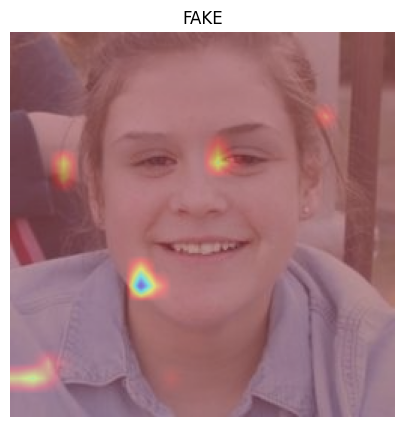

In [6]:
start_index = 10
num_of_images = 1

images_subset = test_dataset.samples[start_index:start_index+num_of_images]

heatmaps = list(map(
    lambda im_data: generate_gradcam(model=model, img=im_data[0], img_tensor=im_data[1], target_layer=model.conv3),
    [get_image(i[0], transform) for i in images_subset])
)

plt.figure(figsize=(15, 5))

for i, h_map in enumerate(heatmaps):
    plt.subplot(1, num_of_images, i + 1)
    plt.imshow(h_map)
    plt.title('FAKE')
    # plt.colorbar()
    plt.axis("off")
plt.show()

tensor([1])


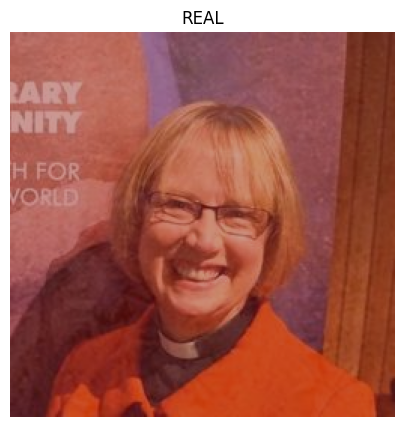

In [7]:
start_index = 5493
num_of_images = 1

images_subset = test_dataset.samples[start_index:start_index+num_of_images]

heatmaps = list(map(
    lambda im_data: generate_gradcam(model=model, img=im_data[0], img_tensor=im_data[1], target_layer=model.conv3, target_class=1),
    [get_image(i[0], transform) for i in images_subset])
)

plt.figure(figsize=(15, 5))

for i, h_map in enumerate(heatmaps):
    plt.subplot(1, num_of_images, i + 1)
    plt.imshow(h_map)
    plt.title('REAL')
    plt.axis("off")
plt.show()

In [35]:
test_dataset.samples[7][0]

'/Users/dimi/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Test/Fake/fake_1003.jpg'

### Evaluation

Test dataset from data used for training

Test accuracy: 91.719
AUC: 0.917


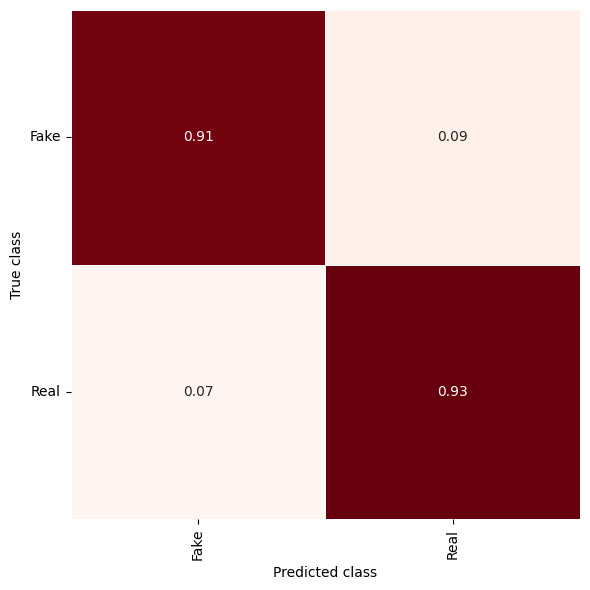

In [8]:
plot_confusion_matrix(evaluate_model(model, test_loader, device, classes), classes)

*StyleGAN Dataset 140k*

In [9]:
_, _, test_dataset = get_xhlulu_140k_real_and_fake_dataset(transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

Test accuracy: 51.670
AUC: 0.517


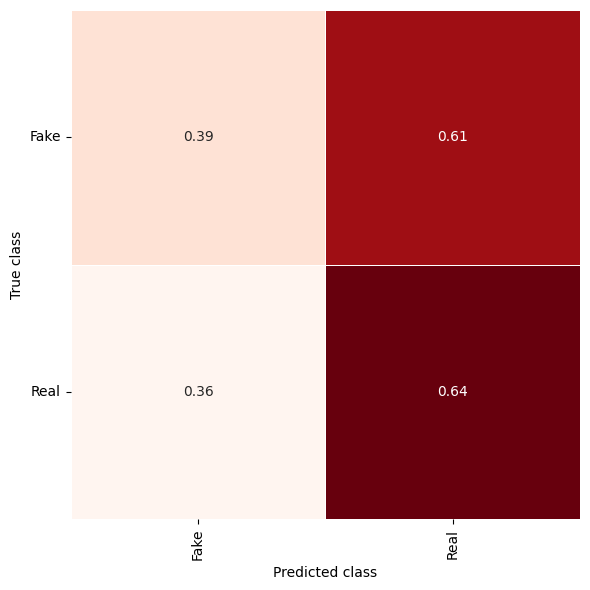

In [10]:
plot_confusion_matrix(evaluate_model(model, test_loader, device, classes), classes)

Some random dataset from Kaggle

Test accuracy: 54.590
AUC: 0.539


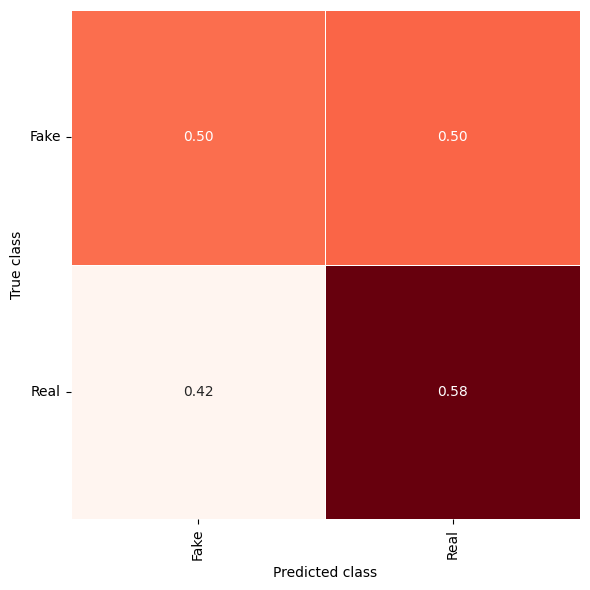

In [11]:
_, _, test_dataset = get_alaaeddineayadi_real_vs_fake_dataset(transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
plot_confusion_matrix(evaluate_model(model, test_loader, device, classes), classes)